# LANL Notebook

Link to competition and dataset: https://www.kaggle.com/c/LANL-Earthquake-Prediction

Anaysis: https://www.kaggle.com/jsaguiar/seismic-data-exploration


## The Dataset
The training dataset has 2 columns (x, y), representing a single, continuous seismic signal.  x is the signal value, and y is the time-to-next-earthquake. The test data consists of segments of seismic signals (x values), and for each signal point in a segment, a time-to-next-earthquake (y) must be predicted by a machine learning model.

The dataset is large with over 600 million data points in the training signal (9 GB in csv format) and working with it will prove to be challenging (loading, visualizing, training models etc.).


## Useful Ideas

1. Downsampling to reduce dataset size:
> There are ways to do this without aliasing error (or minimal aliasing error). See the [Wiki article](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) (short).

2. Noise filtering and other signal enhancements:
> The signal *may* be noisy. Any good filters (especially those used in the seismic domain) will improve our model accuracy.

3. Feature engineering
The raw signal maybe 'too raw' for the RNN to learn useful/ predictive patterns. We may have to engineer features.

    3.1. Feature detecting filters
> Features in signals are usually detected by filters (a filter is defined by its kernel: the impulse response). There may be feature detecting filters already used in the seismic analysis domain. Eg: filters to detect the presence of a peak.

    3.2. Engineering other features
> We can engineering other features such as: does_peak_exist_in_this_window, time_since_last_peak, first_derivative, second_derivative, Fourier transform (DFT) of the window, etc.
    
    3.3. Map data to higher dimension, e.g. using Kernels

4. Automating feature engineering via convolutional nets (CNN)
> CNNs essentially learn the kernels of filters as part of the neural network. We can have some CNN layers before the LSTM layers and see if that works.

5. I checked some of the test files and it seems that the peaks are absent. Hence, I stongly recommend completely eliminating the peaks before training the RNN. Peaks will be considered outliers. 


In [124]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [125]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline  

In [126]:
#Data was convereted from CSV to HDF then truncated
hdf_key = 'my_key'

# Change the following to point to proper local paths
truncated_train_hdf_file = '../LANL-Earthquake-Prediction/truncated_train_hdf.h5' 
validation_hdf_file = '../LANL-Earthquake-Prediction/validation_hdf.h5'
test_hdf_file = '../LANL-Earthquake-Prediction/test_hdf.h5'


In [127]:
def read_hdf(filename, key):
    t0 = time.time()
    print('Reading HDF dataset {}'.format(filename))

    dataset_df = pd.read_hdf(filename, key=key)

    print('Reading complete. time_to_read={}'.format(filename, time.time() - t0))

    return dataset_df  # This is a Pandas DataFrame

In [128]:
def print_info(df):
    print("Dataset shape = {}".format(df.shape))
    df.info(memory_usage='deep')    # Some info about the dataset (memory usage etc.)

    pd.set_option("display.precision", 15)  # Show more decimals
    print(df.head())

    # print(df.acoustic_data.describe())  # Some stats; can take time if dataset is large


def truncate_dataset(df, num_rows_to_keep):
    print('Truncating the dataset. num_rows_to_keep={}'.format(num_rows_to_keep))
    trunc_df = df[:num_rows_to_keep]
    print('Truncating complete. trunc_df.shape={}'.format(trunc_df.shape))
    return trunc_df

In [129]:
def plot_series(df):
    print('Plotting series')
    # plt.plot(series)
    # plt.show()

    fig, ax1 = plt.subplots()

    color = 'tab:orange'
    ax1.set_xlabel('time (#points)')
    ax1.set_ylabel('seismic_signal', color=color)
    ax1.plot(df.acoustic_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('time_to_earthquake', color=color)  # we already handled the x-label with ax1
    ax2.plot(df.time_to_failure, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Import truncated Data from hdf files
### 3 sets: train, validation, test. Print basic stats about them and plot them

In [130]:
train_df = read_hdf(truncated_train_hdf_file, hdf_key)
valid_df = read_hdf(validation_hdf_file, hdf_key)
test_df = read_hdf(test_hdf_file, hdf_key)

Reading HDF dataset ../LANL-Earthquake-Prediction/truncated_train_hdf.h5
Reading complete. time_to_read=../LANL-Earthquake-Prediction/truncated_train_hdf.h5
Reading HDF dataset ../LANL-Earthquake-Prediction/validation_hdf.h5
Reading complete. time_to_read=../LANL-Earthquake-Prediction/validation_hdf.h5
Reading HDF dataset ../LANL-Earthquake-Prediction/test_hdf.h5
Reading complete. time_to_read=../LANL-Earthquake-Prediction/test_hdf.h5


Dataset shape = (139000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 139000000 entries, 0 to 138999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 2.3 GB
   acoustic_data  time_to_failure
0             12     1.4690999832
1              6     1.4690999821
2              8     1.4690999810
3              5     1.4690999799
4              8     1.4690999788
Plotting series


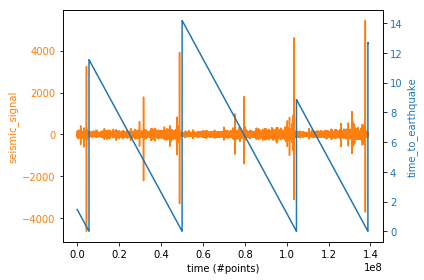

In [104]:
print_info(train_df)
plot_series(train_df) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (80000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000000 entries, 139000000 to 218999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 1.3 GB
           acoustic_data     time_to_failure
139000000              5  12.635497500000001
139000001              3  12.635497499000001
139000002              5  12.635497497999999
139000003             -2  12.635497497000001
139000004              0  12.635497495999999
Plotting series


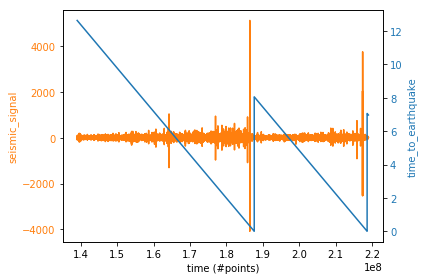

In [8]:
print_info(valid_df)
plot_series(valid_df) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (27000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000000 entries, 219000000 to 245999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 463.5 MB
           acoustic_data    time_to_failure
219000000              1  6.969696360400000
219000001             -1  6.969696359299999
219000002              0  6.969696358200000
219000003              3  6.969696357100000
219000004              6  6.969696356000000
Plotting series


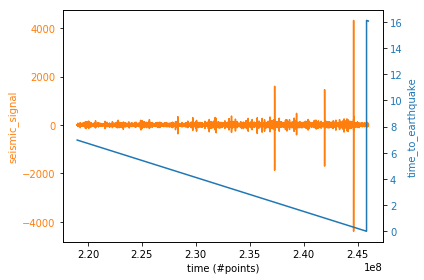

In [9]:
print_info(test_df)
plot_series(test_df) # This is time and memory consuming. Do not run this cell unless necessary

# Understanding Data

## Domain Perspective

https://www.youtube.com/watch?v=T0AEtX-uPLA
- Earthquakes occur when two parts of the earth suddenly move in relation to each other
- Earthequake originates at a point in earth called focus and spreads up to the surface at a point called Epicenter.
- A seismograph detects and records seismic waves. \n",
- Types of Seismic waves include:  Pressure (or Primary) Waves (P-Waves), Shear (or Secondary) Waves (S-Waves) and Surface Waves. P-Waves and S-Waves are both Body waves.

https://courses.lumenlearning.com/geophysical/chapter/earthquake-prediction/
- Predciting when an earthquake will occur is more difficult than predicting where it will occur.
- Sometimes (not always) earthquakes occur few seconds to few weeks after foreshocks.

https://en.wikipedia.org/wiki/P-wave
- P-Wave travel faster and hence are the first waves to reach sesimograph. They propagate through gases, liguids or solids. \n",
- S-Waves are attenuated by liquids.\n",
- P-Waves are non-destructive, while both S-Waves and Surfcae Waves are destructive. \n",
- Earthquake warning is possible if P-Waves are detected. Advanced warning time is dependent on the delay beween the arrival of P-wave and the arrival of the first destructive waves. This delay is a function of how deep the focus is, nature of earth layers and others. It ranges from few seconds to 90 seconds. Ground vibrations resulting from truck movement and contruction activitoes on earth shall be rejected for accurate detection of P-waves.

https://www.bgs.ac.uk/discoveringGeology/hazards/earthquakes/

## Statistical Perspective

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

We need to test data for random-walk/stochasiticity, e.g. correlation tests on both signal (f) and (df), covariance test?!



In [207]:
train_df.max()

acoustic_data      5444.000000000000000
time_to_failure      14.180599989999999
dtype: float64

In [208]:
train_df.min()

acoustic_data     -4621.00000000000000
time_to_failure       0.00069548217471
dtype: float64

# Recurrent Neural Network - LSTM

## Part 1 - Data Preprocessing

In [209]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [210]:
# Importing the training set
"""Temporary: we downsample the training datatset to reduce time!"""
down_sample=40000
dataset_train = train_df.iloc[::down_sample,:]
training_set = dataset_train.iloc[:, 0:2].values
print("Training will be performed on downsampled dataset which consists of ",dataset_train.shape[0],
      " examples out of the original number of training examples which is ", train_df.shape[0])

Training will be performed on downsampled dataset which consists of  3475  examples out of the original number of training examples which is  139000000


In [211]:
dataset_train.info()
dataset_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3475 entries, 0 to 138960000
Data columns (total 2 columns):
acoustic_data      3475 non-null int16
time_to_failure    3475 non-null float64
dtypes: float64(1), int16(1)
memory usage: 61.1 KB


,acoustic_data,time_to_failure
0,12,1.4690999832
40000,8,1.4595965336
80000,-1,1.4488975896
120000,4,1.4382986456
160000,9,1.4275997016


In [212]:
# Feature Scaling - Ignored for now
"""
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler (feature_range=(0, 1))
training_set_scaled = sc.fit_transform (training_set) 
"""
training_set_scaled = training_set

In [213]:
# Creating a data structure with 100 timesteps and 1 output

"""Temporary: 100 (steps in the past) is picked randomly while it should be carefully studied"""
time_steps=100

X_train = []
y_train = []

    
for i in range (time_steps, training_set_scaled.shape[0]): 
    X_train.append (training_set_scaled[i - time_steps:i, 0])
    y_train.append (training_set_scaled[i, 1])
X_train, y_train = np.array (X_train), np.array (y_train)

# Reshaping since RNN accepts 3d input
X_train = np.reshape (X_train, (X_train.shape[0], X_train.shape[1], 1))
print ("The 3d shape necessary for RNN's input is ", X_train.shape, " . Note how the number of examples is reduced by the defined time steps, i.e. ", time_steps)  

The 3d shape necessary for RNN's input is  (3375, 100, 1)  . Note how the number of examples is reduced by the defined time steps, i.e.  100


In [214]:
#Check
print(training_set_scaled[99,0], " ", training_set_scaled[100,1])
print(X_train[0,99,0]," ", y_train[0])

7.0   0.43069744882
7.0   0.43069744882


## Part 2 - Building the RNN

In [215]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential ()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add (Dropout (0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50, return_sequences=True))
regressor.add (Dropout (0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50, return_sequences=True))
regressor.add (Dropout (0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50))
regressor.add (Dropout (0.2))

# Adding the output layer
regressor.add (Dense (units=1))

# Compiling the RNN
regressor.compile (optimizer='adam', loss='mean_squared_error')

## Part 3 - Training the RNN

In [216]:
print('Training the RNN with the training set')
regressor.fit (X_train, y_train, epochs=3, batch_size=32)
print('Training complete')

Training the RNN with the training set
Epoch 1/3
3375/3375 [==============================] - 61s 18ms/step - loss: 17.2971
Epoch 2/3
3375/3375 [==============================] - 58s 17ms/step - loss: 13.8613
Epoch 3/3
3375/3375 [==============================] - 58s 17ms/step - loss: 13.2465
Training complete


## Part 4 - Making the predictions and visualising the results

In [217]:
# Import validation set
"""Temporary: we downsample the testing datatset to reduce time!"""
dataset_test = valid_df.iloc[::down_sample,:]
real_time = dataset_test.iloc[:,1].values
print("Validation will be performed on truncated dataset which consists of ",dataset_test.shape[0],
      " examples out of the original number of training examples which is ", valid_df.shape[0])

Validation will be performed on truncated dataset which consists of  2000  examples out of the original number of training examples which is  80000000


In [218]:
dataset_test.info()
dataset_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 139000000 to 218960000
Data columns (total 2 columns):
acoustic_data      2000 non-null int16
time_to_failure    2000 non-null float64
dtypes: float64(1), int16(1)
memory usage: 35.2 KB


,acoustic_data,time_to_failure
139000000,5,12.635497500000001
139040000,10,12.624898556000000
139080000,4,12.614199612000000
139120000,8,12.604696163000000
139160000,7,12.593997219000000


In [219]:
#Because we have 100 time steps and we we want to predict the first entry of time_to_failure in the validation set, we have to look back 100 samples. 
#Hence, we get these 100 past samples from the training set. This is why we first concatenate both training and validation. This step may be omitted if we just need to predict one value
#for the whole test set (such as in the provided test files where one value is only needed so we can look back in the same data provided ) 
dataset_total = pd.concat((dataset_train['acoustic_data'], dataset_test['acoustic_data']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps:].values
inputs = inputs.reshape(-1,1)
#inputs_scaled = sc.transform(inputs)
inputs_scaled=inputs
inputs_scaled.shape # So we end up with input size = size of validation set + 100

(2100, 1)

In [220]:
X_test = []

for i in range(time_steps, inputs_scaled.shape[0]):
    X_test.append(inputs_scaled[i-time_steps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(2000, 100, 1)

In [221]:
predicted_time = regressor.predict(X_test)
#predicted_time = sc.inverse_transform(predicted_time)

In [222]:
prediction=pd.DataFrame(predicted_time)
prediction.to_csv(r'prediction.csv')

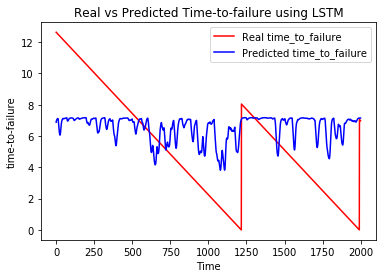

In [223]:
# Visualising the results
plt.plot(real_time, color = 'red', label = 'Real time_to_failure')
plt.plot(predicted_time, color = 'blue', label = 'Predicted time_to_failure')
plt.title('Real vs Predicted Time-to-failure using LSTM')
plt.xlabel('Time')
plt.ylabel('time-to-failure')
plt.legend()
plt.show()